## Day 85 Lecture 1 Assignment

In this assignment, we will learn how to use the other layers to improve our model performance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import concatenate, Dense, LSTM, Embedding, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from sklearn.metrics import  classification_report, confusion_matrix

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We will explore a dataset containing information about twitter users and will detect whether or not the user is a bot.

In [3]:
twitter = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/training_data_2_csv_UTF.csv')

In [4]:
twitter.head()

,id,id_str,screen_name,location,description,url,followers_count,friends_count,listed_count,created_at,favourites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot
0,8.160000e+17,"""815745789754417152""","""HoustonPokeMap""","""Houston, TX""","""Rare and strong PokŽmon in Houston, TX. See m...","""https://t.co/dnWuDbFRkt""",1291,0,10,"""Mon Jan 02 02:25:26 +0000 2017""",0,False,78554,"""en""","{\r ""created_at"": ""Sun Mar 12 15:44:04 +0...",True,False,False,"""Houston PokŽ Alert""",1
1,4.843621e+09,4843621225,kernyeahx,"Templeville town, MD, USA",From late 2014 Socium Marketplace will make sh...,NaN,1,349,0,2/1/2016 7:37,38,False,31,en,NaN,True,False,False,Keri Nelson,1
2,4.303727e+09,4303727112,mattlieberisbot,NaN,"Inspired by the smart, funny folks at @replyal...",https://t.co/P1e1o0m4KC,1086,0,14,Fri Nov 20 18:53:22 +0000 2015,0,False,713,en,"{'retweeted': False, 'is_quote_status': False,...",True,False,False,Matt Lieber Is Bot,1
3,3.063139e+09,3063139353,sc_papers,NaN,NaN,NaN,33,0,8,2/25/2015 20:11,0,False,676,en,Construction of human anti-tetanus single-chai...,True,True,False,single cell papers,1
4,2.955142e+09,2955142070,lucarivera16,"Dublin, United States",Inspiring cooks everywhere since 1956.,NaN,11,745,0,1/1/2015 17:44,146,False,185,en,NaN,False,False,False,lucarivera16,1


In [5]:
twitter.shape

(2797, 20)

Start by getting rid of all columns that are not useful.

In [6]:
# drop columns that aren't useful
not_useful = ['id','id_str','url','created_at','status']
twitter2 = twitter.drop(not_useful, axis=1)


Next, get rid of all columns that contain more than 30% missing data. After that, remove all rows containing at least one missing observation.

In [7]:
# function to calculate percentage of missing values by column
def missingness_summary(df,sort='descending',print_log=True,):
  percentage_null = df.isnull().sum()*100/df.isnull().count()
  if sort == 'ascending':
    return percentage_null.sort_values()
  elif sort == 'descending':
    return percentage_null.sort_values(ascending=False)
  else: 
    return percentage_null


In [8]:
missingness_summary(twitter2)

location                 36.467644
description              14.408295
has_extended_profile      3.539507
bot                       0.000000
name                      0.000000
default_profile_image     0.000000
default_profile           0.000000
lang                      0.000000
statuses_count            0.000000
verified                  0.000000
favourites_count          0.000000
listed_count              0.000000
friends_count             0.000000
followers_count           0.000000
screen_name               0.000000
dtype: float64

In [9]:
twitter3 = twitter2.drop('location',axis=1)
twitter4 = twitter3.dropna()

missingness_summary(twitter4)

bot                      0.0
name                     0.0
has_extended_profile     0.0
default_profile_image    0.0
default_profile          0.0
lang                     0.0
statuses_count           0.0
verified                 0.0
favourites_count         0.0
listed_count             0.0
friends_count            0.0
followers_count          0.0
description              0.0
screen_name              0.0
dtype: float64

Now we will use our embedding functions from a previous assignment.

In [10]:
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words)       

def stem_list(word_list):
    stemmed = []
    for word in word_list:
        stemmedword = stemmer.stem(word)
        stemmed.append(stemmedword)
    return stemmed

def normalize(terms):
    terms = terms.lower()
    terms = remove_stopwords(terms)
    word_delimiters = u'[\\[\\]\n.!?,;:\t\\-\\"\\(\\)\\\'\u2019\u2013 ]'
    term_list = re.split(word_delimiters, terms)
    trimmed = [x.rstrip() for x in term_list]
    stemmed = stem_list(trimmed)
    space = ' '
    normed = space.join(stemmed)
    normed = normed.replace('  ', ' ')
    return normed

We will create two branches, one branch will process the text data in the description and the other will process all other columns. First, create a numpy array with the encoded data from the description column. Normalize each description, one hot encode the text, pad the row and create a numpy array.

In [11]:
# normalize text into a np array
twitter4['normalized_text'] = [normalize(word) for word in np.array(twitter4['description'])]
twitter4['normalized_text'][:5]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0     rare strong pokžmon houston tx see pokžmon ht...
1    late 2014 socium marketplac make shop fundamen...
2    inspir smart funni folk @replyal @gimletmedia ...
4                     inspir cook everywher sinc 1956 
5            guy tri good tell everyon els get better 
Name: normalized_text, dtype: object

Convert all boolean variables to numeric (zero for false and 1 for true)

In [12]:
# convert bools to numeric
twitter5 = twitter4.replace({True:1, False:0})
twitter5.head()


,screen_name,description,followers_count,friends_count,listed_count,favourites_count,verified,statuses_count,lang,default_profile,default_profile_image,has_extended_profile,name,bot,normalized_text
0,"""HoustonPokeMap""","""Rare and strong PokŽmon in Houston, TX. See m...",1291,0,10,0,0,78554,"""en""",1,0,0,"""Houston PokŽ Alert""",1,rare strong pokžmon houston tx see pokžmon ht...
1,kernyeahx,From late 2014 Socium Marketplace will make sh...,1,349,0,38,0,31,en,1,0,0,Keri Nelson,1,late 2014 socium marketplac make shop fundamen...
2,mattlieberisbot,"Inspired by the smart, funny folks at @replyal...",1086,0,14,0,0,713,en,1,0,0,Matt Lieber Is Bot,1,inspir smart funni folk @replyal @gimletmedia ...
4,lucarivera16,Inspiring cooks everywhere since 1956.,11,745,0,146,0,185,en,0,0,0,lucarivera16,1,inspir cook everywher sinc 1956
5,dantheimprover,Just a guy trying to do good by telling everyo...,1,186,0,0,0,11,en,1,0,1,dantheimprover,1,guy tri good tell everyon els get better


Create dummy variables out of the relevant object columns. Take caution when converting columns that may incorrectly classified as object.

In [13]:
# identify potential continuous columns by making a loop for unique values in categorical columns
for col in twitter5.columns:
    if twitter5[col].dtypes == 'O': 
        print(f'{col} unique values: {twitter5[col].nunique()}')


screen_name unique values: 2348
description unique values: 2317
lang unique values: 28
name unique values: 2337
normalized_text unique values: 2313


In [14]:
# let's drop screen_name and name since they won't be useful, 
## let's also drop desriction because we have that data represented in our normalized column
twitter6 = twitter5.drop(['screen_name','description','name'],axis=1)
twitter6.head()

,followers_count,friends_count,listed_count,favourites_count,verified,statuses_count,lang,default_profile,default_profile_image,has_extended_profile,bot,normalized_text
0,1291,0,10,0,0,78554,"""en""",1,0,0,1,rare strong pokžmon houston tx see pokžmon ht...
1,1,349,0,38,0,31,en,1,0,0,1,late 2014 socium marketplac make shop fundamen...
2,1086,0,14,0,0,713,en,1,0,0,1,inspir smart funni folk @replyal @gimletmedia ...
4,11,745,0,146,0,185,en,0,0,0,1,inspir cook everywher sinc 1956
5,1,186,0,0,0,11,en,1,0,1,1,guy tri good tell everyon els get better


The language column is our only true categorical column

In [15]:
twitter6['lang'].value_counts()

en         2065
"en"        100
pt           55
en-gb        53
es           21
de            9
fr            8
"ja"          6
it            6
ja            4
"es"          3
"pt"          3
zh-cn         2
zh-CN         2
nl            2
tr            2
ru            2
"en-gb"       2
"it"          1
"zh-CN"       1
th            1
"zh-cn"       1
"da"          1
gl            1
"fr"          1
ta            1
"ko"          1
ar            1
Name: lang, dtype: int64

Further cleaning of the language column is needed.

In [16]:
# function that will remove excess quote marks and lower case everything
def text_cleaner(text):
    # remove quotes
    text = re.sub("[\"\']", "", text)
    text = ' '.join(text.split())
    return text.lower()

In [17]:
twitter6['lang'] = [text_cleaner(word) for word in twitter6['lang']]

twitter6['lang'].value_counts()

en       2165
pt         58
en-gb      55
es         24
ja         10
fr          9
de          9
it          7
zh-cn       6
nl          2
tr          2
ru          2
th          1
ko          1
gl          1
ta          1
da          1
ar          1
Name: lang, dtype: int64

In [18]:
# create dummy variables for lang column
twitter7 = pd.get_dummies(twitter6,columns=['lang'])

twitter7.head()

,followers_count,friends_count,listed_count,favourites_count,verified,statuses_count,default_profile,default_profile_image,has_extended_profile,bot,normalized_text,lang_ar,lang_da,lang_de,lang_en,lang_en-gb,lang_es,lang_fr,lang_gl,lang_it,lang_ja,lang_ko,lang_nl,lang_pt,lang_ru,lang_ta,lang_th,lang_tr,lang_zh-cn
0,1291,0,10,0,0,78554,1,0,0,1,rare strong pokžmon houston tx see pokžmon ht...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,349,0,38,0,31,1,0,0,1,late 2014 socium marketplac make shop fundamen...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1086,0,14,0,0,713,1,0,0,1,inspir smart funni folk @replyal @gimletmedia ...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,11,745,0,146,0,185,0,0,0,1,inspir cook everywher sinc 1956,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,186,0,0,0,11,1,0,1,1,guy tri good tell everyon els get better,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Min max scale the data decribing each user (do not min max scale the word embeddings).

In [19]:
# min max scale continuous columns
scale = MinMaxScaler()

counts = twitter7.filter(like='_count')
counts_scaled = pd.DataFrame(scale.fit_transform(counts), columns=counts.columns)

twitter8 = pd.concat([counts_scaled, twitter7.drop(columns=counts.columns).reset_index()], axis=1)
twitter8.head()



,followers_count,friends_count,listed_count,favourites_count,statuses_count,index,verified,default_profile,default_profile_image,has_extended_profile,bot,normalized_text,lang_ar,lang_da,lang_de,lang_en,lang_en-gb,lang_es,lang_fr,lang_gl,lang_it,lang_ja,lang_ko,lang_nl,lang_pt,lang_ru,lang_ta,lang_th,lang_tr,lang_zh-cn
0,1.340302e-05,0.000000,0.000016,0.000000,0.011445,0,0,1,0,0,1,rare strong pokžmon houston tx see pokžmon ht...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.038189e-08,0.000354,0.000000,0.000053,0.000005,1,0,1,0,0,1,late 2014 socium marketplac make shop fundamen...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.127473e-05,0.000000,0.000023,0.000000,0.000104,2,0,1,0,0,1,inspir smart funni folk @replyal @gimletmedia ...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.142008e-07,0.000756,0.000000,0.000204,0.000027,4,0,0,0,0,1,inspir cook everywher sinc 1956,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.038189e-08,0.000189,0.000000,0.000000,0.000002,5,0,1,0,1,1,guy tri good tell everyon els get better,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
twitter9 = twitter8.drop('index',axis=1)
twitter9.head()

,followers_count,friends_count,listed_count,favourites_count,statuses_count,verified,default_profile,default_profile_image,has_extended_profile,bot,normalized_text,lang_ar,lang_da,lang_de,lang_en,lang_en-gb,lang_es,lang_fr,lang_gl,lang_it,lang_ja,lang_ko,lang_nl,lang_pt,lang_ru,lang_ta,lang_th,lang_tr,lang_zh-cn
0,1.340302e-05,0.000000,0.000016,0.000000,0.011445,0,1,0,0,1,rare strong pokžmon houston tx see pokžmon ht...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.038189e-08,0.000354,0.000000,0.000053,0.000005,0,1,0,0,1,late 2014 socium marketplac make shop fundamen...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.127473e-05,0.000000,0.000023,0.000000,0.000104,0,1,0,0,1,inspir smart funni folk @replyal @gimletmedia ...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.142008e-07,0.000756,0.000000,0.000204,0.000027,0,0,0,0,1,inspir cook everywher sinc 1956,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.038189e-08,0.000189,0.000000,0.000000,0.000002,0,1,0,1,1,guy tri good tell everyon els get better,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
# define x and y
X = twitter9.drop(['bot'], axis=1)
y = twitter9['bot']

In [22]:
# inspect X
X.head()

,followers_count,friends_count,listed_count,favourites_count,statuses_count,verified,default_profile,default_profile_image,has_extended_profile,normalized_text,lang_ar,lang_da,lang_de,lang_en,lang_en-gb,lang_es,lang_fr,lang_gl,lang_it,lang_ja,lang_ko,lang_nl,lang_pt,lang_ru,lang_ta,lang_th,lang_tr,lang_zh-cn
0,1.340302e-05,0.000000,0.000016,0.000000,0.011445,0,1,0,0,rare strong pokžmon houston tx see pokžmon ht...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.038189e-08,0.000354,0.000000,0.000053,0.000005,0,1,0,0,late 2014 socium marketplac make shop fundamen...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.127473e-05,0.000000,0.000023,0.000000,0.000104,0,1,0,0,inspir smart funni folk @replyal @gimletmedia ...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.142008e-07,0.000756,0.000000,0.000204,0.000027,0,0,0,0,inspir cook everywher sinc 1956,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.038189e-08,0.000189,0.000000,0.000000,0.000002,0,1,0,1,guy tri good tell everyon els get better,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
# split X train and X test sets by numeric and text data
X_train_num = X_train.drop(['normalized_text'], axis=1)
X_test_num = X_test.drop(['normalized_text'], axis=1)
X_train_text = X_train['normalized_text']
X_test_text = X_test['normalized_text']


In [25]:
X_train_num.head()

,followers_count,friends_count,listed_count,favourites_count,statuses_count,verified,default_profile,default_profile_image,has_extended_profile,lang_ar,lang_da,lang_de,lang_en,lang_en-gb,lang_es,lang_fr,lang_gl,lang_it,lang_ja,lang_ko,lang_nl,lang_pt,lang_ru,lang_ta,lang_th,lang_tr,lang_zh-cn
538,0.000013,0.002674,0.000039,0.000035,0.000097,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
843,0.000905,0.015445,0.000648,0.001076,0.000104,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2192,0.000002,0.003978,0.000003,0.000494,0.000009,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2347,0.010092,0.003116,0.002558,0.001993,0.003258,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1825,0.000016,0.000788,0.000015,0.039520,0.006161,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
X_train_text

538      social media manag seo web design graphic des...
843     passion invent technolog connect empow peopl a...
2192    hello african indian artist work pub design cu...
2347    hailey rhode baldwin instagramäó¢haileybaldwin...
1825                        anoth one bite dust || dancer
                              ...                        
1183                          never depend nobodi myself 
1834                                             let beau
660     random raw imag outer planet probe accompani c...
1475            troca de livro livro literatura livraria 
862                                instagram trviswilliam
Name: normalized_text, Length: 1884, dtype: object

In [27]:
X_test_text 

2009    instagram parineetichopra snapchat chopraparin...
595     ceo @influenceandco @forb @inc columnist speak...
525     electr eye judg elast citi 1/day bot @tullyhan...
408     gentl spell help you say request i ll write gr...
1867    break technolog news analysi opinion techcrunc...
                              ...                        
2006                human version doubl yellow starburst 
1252                               whatev take make smile
1830                                 founder presid udac 
896                      amdifer ig zowowmdledl love life
1857    i m pc technician share free app news gadget t...
Name: normalized_text, Length: 471, dtype: object

In [28]:
# complete preprocessing text data
# create vocab for one hot encode
vocab = " ".join(X_train_text.tolist())
vocab = vocab.split(" ")
vocab = list(filter(None, vocab))
vocab_size = len(set(vocab))
vocab_size

6882

In [29]:
# one hot encode each word
encoded_tweets = [one_hot(tweet, vocab_size) for tweet in X_train_text]
# pad the encoded sequences
X_train_text = pad_sequences(encoded_tweets)

In [30]:
# vecotorize x test text data
encoded_tweets = [one_hot(tweet, vocab_size) for tweet in X_test_text]
# pad the encoded sequences
X_test_text = pad_sequences(encoded_tweets)

In [31]:
X_train_text.shape, X_test_text.shape

((1884, 66), (471, 25))

In [32]:
# left pad X_test_text to match the same dimensions as X_train_text
X_test_text_pad = np.pad(X_test_text,((0,0),((X_train_text.shape[1]-X_test_text.shape[1]),0)), 'constant')

In [33]:
X_train_text.shape, X_test_text_pad.shape

((1884, 66), (471, 66))

In [34]:
X_test_text_pad[:1]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0, 6078, 3590, 6404,  513]],
      dtype=int32)

In [35]:
X_test_text = X_test_text_pad

Now we'll create the two branches. Create a model for the numeric data that consists of 3 dense layers. An input layer and two hidden layers of size 32.

In [36]:
# layer 1 - numeric branch

# create input
inputs_num = Input(shape=X_train_num.shape[1],)

# hidden layers
h1_num = Dense(32, activation='relu')(inputs_num)
path_num = Dense(32, activation='relu')(h1_num)

Create the second branch of the model using the encoded words. This branch will consist of 4 layers: An input layer, an embedding layer returning data of dimension 100, an LSTM layer of unit size 32 and a dense layer of unit size 32. 

In [37]:
X_train_text.shape[1]

66

In [38]:
# layer 2 - text branch

# create input
inputs_text = Input(shape=X_train_text.shape[1])
# embedding layer
embed_text = Embedding(input_dim=vocab_size+1, output_dim=100)(inputs_text)
# lstm layer
lstm_text = LSTM(32)(embed_text)
# hidden layers
path_text = Dense(32, activation='relu')(lstm_text)


Merge the two models using the `concatenate` function (merge the two final dense layers in each branch) and create an output dense layer.

In [39]:
# concatenate both paths
merge = concatenate([path_num,path_text])

output = Dense(1, activation='sigmoid')(merge)
#output = Dense(1, activation='sigmoid')(path_text)

Create a model using the two inputs and the single output and print the summary

In [40]:
# create model
#model = Model(inputs=inputs_text, outputs=output)
model = Model(inputs=[inputs_num,inputs_text], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 66)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 66, 100)      688300      input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           896         input_1[0][0]                    
______________________________________________________________________________________________

Compile and fit the model using the appropriate optimizer, loss, and metrics. Train the model for 10 epochs with a batch size of 128.

In [41]:
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
history = model.fit([X_train_num,X_train_text], y_train, validation_data=([X_test_num,X_test_text], y_test), epochs=50, batch_size=128)
    
    

Epoch 1/50
15/15 [==============================] - 4s 59ms/step - loss: 0.6754 - accuracy: 0.7527 - val_loss: 0.6467 - val_accuracy: 0.7197
Epoch 2/50
15/15 [==============================] - 0s 17ms/step - loss: 0.6282 - accuracy: 0.7587 - val_loss: 0.5846 - val_accuracy: 0.7983
Epoch 3/50
15/15 [==============================] - 0s 17ms/step - loss: 0.5285 - accuracy: 0.8274 - val_loss: 0.4630 - val_accuracy: 0.8386
Epoch 4/50
15/15 [==============================] - 0s 17ms/step - loss: 0.3224 - accuracy: 0.9301 - val_loss: 0.4185 - val_accuracy: 0.7919
Epoch 5/50
15/15 [==============================] - 0s 17ms/step - loss: 0.1639 - accuracy: 0.9584 - val_loss: 0.3840 - val_accuracy: 0.8344
Epoch 6/50
15/15 [==============================] - 0s 17ms/step - loss: 0.1015 - accuracy: 0.9799 - val_loss: 0.4345 - val_accuracy: 0.8301
Epoch 7/50
15/15 [==============================] - 0s 17ms/step - loss: 0.0613 - accuracy: 0.9885 - val_loss: 0.4996 - val_accuracy: 0.8153
Epoch 8/50
15

In [42]:
def results(model,history,model_name='Model'):
  # dataframe with epoch history
  model_df = pd.DataFrame(history.history)
  # plot model loss over epochs
  model_df[['loss', 'val_loss']].plot(figsize=(20,10))
  plt.title(f'{model_name} Loss'.capitalize() )
  plt.show()
  # plot model accuracy over epochs
  model_df[['accuracy', 'val_accuracy']].plot(figsize=(20,10))
  plt.title(f'{model_name} Accuracy'.capitalize() )
  plt.show()  
  # final epoch model results
  results = model.evaluate([X_test_num,X_test_text], y_test, verbose=0)
  print(f'{model_name} Loss: '.capitalize() , round(results[0],6))
  print(f'{model_name} Accuracy: '.capitalize() , round(results[1],6))

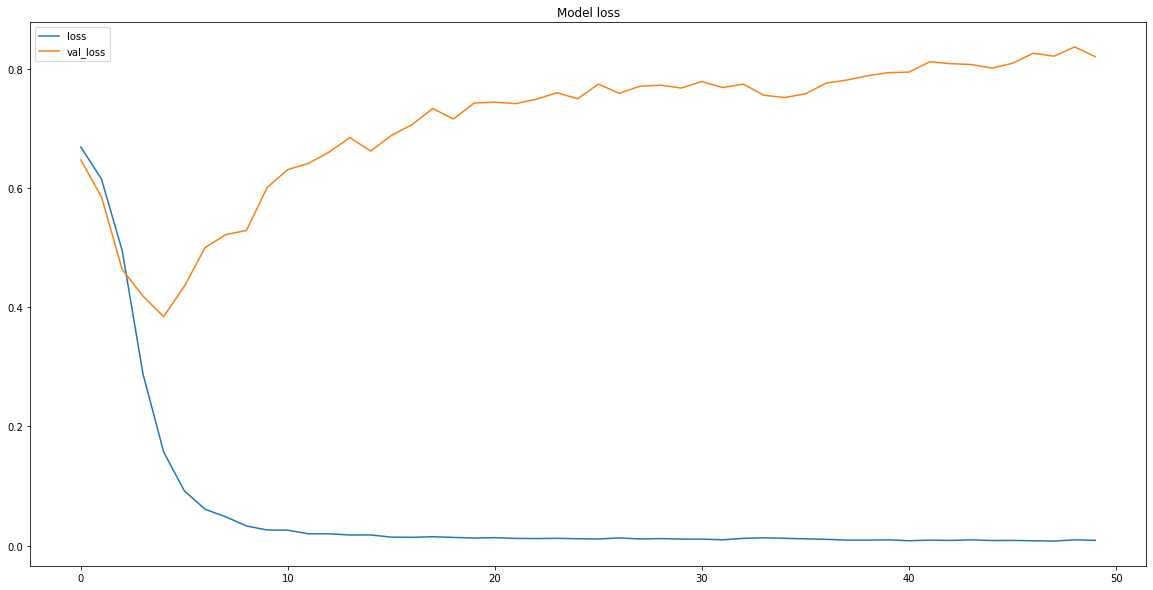

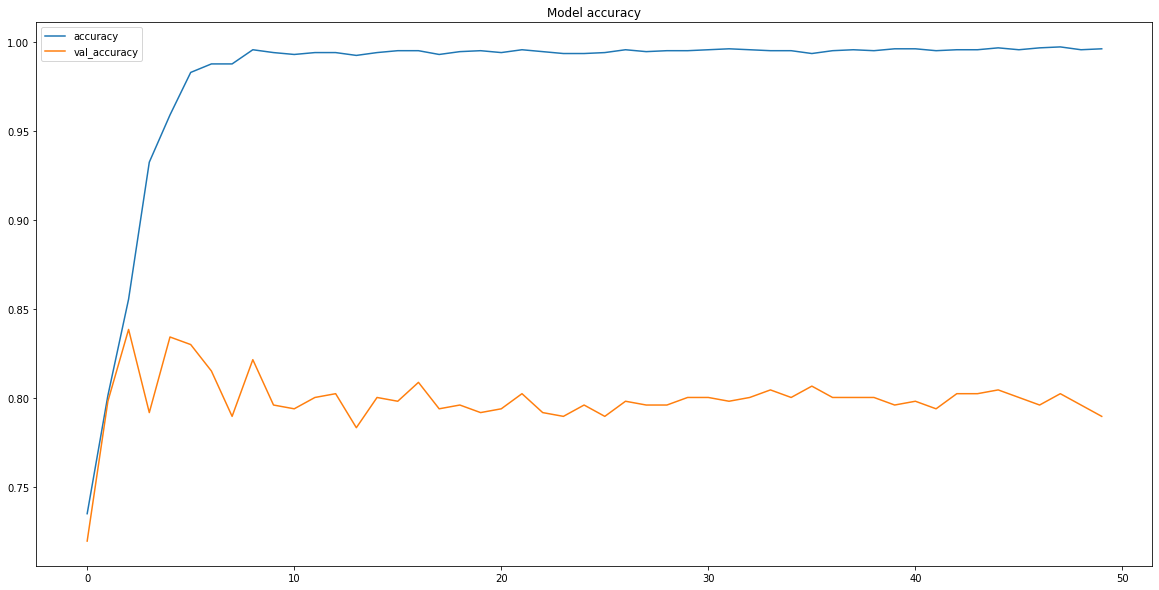

Model loss:  0.819883
Model accuracy:  0.789809


In [43]:
results(model, history)

In [44]:
#plot confustion matric helper function
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Given a scikit-learn confusion matrix (CM), make a nice plot.

    Arguments
    ---------
    cm:           Confusion matrix from sklearn.metrics.confusion_matrix

    target_names: Given classification classes, such as [0, 1, 2]
                  The class names, for example, ['high', 'medium', 'low']

    title:        The text to display at the top of the matrix

    cmap:         The gradient of the values displayed from matplotlib.pyplot.cm
                  See http://matplotlib.org/examples/color/colormaps_reference.html
                  `plt.get_cmap('jet')` or `plt.cm.Blues`

    normalize:    If `False`, plot the raw numbers
                  If `True`, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # Confusion matrix created by
                                                              # `sklearn.metrics.confusion_matrix`
                          normalize    = True,                # Show proportions
                          target_names = y_labels_vals,       # List of names of the classes
                          title        = best_estimator_name) # Title of graph

    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [45]:
# get y test preds for combined model
y_test_pred = pd.Series(model.predict([X_test_num,X_test_text]).flatten() > 0.5) *1
y_test_pred

0      0
1      0
2      1
3      1
4      0
      ..
466    1
467    0
468    0
469    0
470    1
Length: 471, dtype: int64

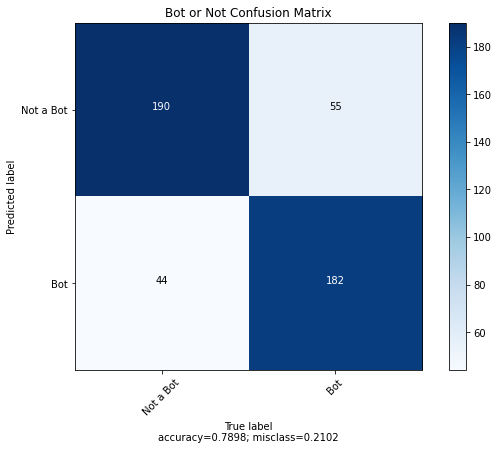

In [46]:
# plot model confusion matrix
confusion = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm=confusion, target_names=['Not a Bot','Bot'],title = 'Bot or Not Confusion Matrix',normalize=False)

In [47]:
# model classifcation report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79       245
           1       0.77      0.81      0.79       226

    accuracy                           0.79       471
   macro avg       0.79      0.79      0.79       471
weighted avg       0.79      0.79      0.79       471

